# **[Term Project] 자동차 생산 공정 데이터 분석을 통한 생산성 개선 방안 도출**

4조
- 2018**** 김창영
- 2020**** 김현서
- 2020**** 변준형
- 2022**** 이준우


# 1. 문제 정의

### __목적__

- 데이터 EDA 및 데이터 분석을 통한 자동차 제조 공정 생산성 개선방향 도출
- 제조 공정의 설비와 모델별 가동률 등을 포함한 공정 데이터와 작업자 정보 데이터를 기반으로 공정내 문제점과 해결방안을 제시하여 생산성 개선 도모하는 것이 목표

- 개선 방법
  - 생산수량 증가: 데이터를 분석하여 생산 공정의 효율성을 개선하고, 공정내의 문제점 해결로 생산량을 증가시키는 방안
  - 가동률 증가: 공정 데이터 분석을 통해 가동률에 부정적인 영향을 끼치는 요소를 파악하고 해결하여 전체적인 가동률 향상
  - 불량률 감소: 제조 공정 중 발생하는 불량수량에 영향을 끼치는 요소를 파악하고 분석하여 불량률 감소

## Data Dictionary

### [Data 1] process.xlsx

- 자동차 생산 공정의 process 데이터로 설비와 모델의 가동률 등 정량적인 데이터가 포함되어 있음

| 변수명 | 정의 | dtype | 설명 |
|-|-|-|-|
| 설비 | 작업이 진행된 설비 | str | LINE_A, LINE_B, LINE_C |
| 근무조 | 교대근무에 따른 근무조 | str | 야간, 주간 |
| 모델 | 생산 모델 | str | 니로, 소나타, 아반떼, 아이오닉, 투싼, 플러그인투싼 |
| 생산수량 | 생산 수량 | int | 해당 근무조의 생산량 |
| 가동률 | $ 가동시간 \div 조업시간 $ | float | 전체 조업시간 중 설비가 실제로 가동된 가동시간의 비율 |
| 시간가동률 | $ 가동시간 \div 부하시간 $ | float | 부하시간 중 설비의 고장 정지, 기종 변경, 자재 품절, 유실 기간 등의 정지시간을 제외한 가동시간과 부하시간의 비율로 설비가 정지 없이 가동되고 있는가를 나타내는 지표 |
| 성능가동률 | $ 생산량 \times 단위생산시간 / 가동시간 $ | float | $ (생산량 \times 이론적단위생산시간)/가동시간 $ 으로, 가동 시간 중 설비 목표 성능을 발휘한 시간의 비율 |
| 불량수량 | 생산 수량 중 불량 수량 | int | |
| 작업자_사번 | 작업자 사번 | int | |

- 조업시간
    - 1일 근무시간을 기초로 하루의 시업 시간과 종업 시간 사이의 총 시간
    - 휴식, 식사 수주물량 부족 등 `계획정지시간`을 포함
- 부하시간
    - `부하시간`=`조업시간` - `계획정지시간`
    - `조업시간`에서 `계획정지시간`을 제외하고 설비가 정상적인 상태에서 실제로 가동되어야 할 시간
- 가동시간
    - `가동시간` = `부하시간` - `정지시간`
    - 설비의 `부하시간`에서 `정지시간`을 제외한 시간으로, 설비가 실제 가동한 시간을 의미함
    - `정지시간`이란 비계획적으로 설비의 작동이 정지된 시간으로 설비가 5분 이상 가동하지 않은 시간을 의미함

### [Data 2] worker.xlsx

- 생산 공정 내의 작업자들의 데이터로 성별과 최종학력 등의 데이터가 포함되어 있음

| 변수명 | 정의 | dtype | 설명 |
|-|-|-|-|
| 사번 | 작업자 사번 | int | |
| 성명 | 작업자 성명 | str | |
| 나이 | 작업자 나이 | int | |
| 성별 | 작업자 성별 | str | 남, 여 |
| 최종학력 | 작업자 최종학력 | str | 고등학교, 전문대학, 대학 |
| 입사일자 | 작업자 입사일자 | date | 연-월-일 |


# 2. 데이터 준비

## 한글 폰트 설치
- 한글 폰트 설치 후 런타임 재시작 필요


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,344 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and dire

## Import Library

- 분석에 필요한 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumBarunGothic')
sns.set_palette("Set2", 10)

## 데이터 불러오기

In [ ]:
!gdown 1AX7tq815PP3FHIBrZZgYJZAt42cAAucf # process.xlsx
!gdown 13fUZ_74qQ9b1KhIlVRU7KuDygxCW6Nxa # worker.xlsx

Downloading...
From: https://drive.google.com/uc?id=1AX7tq815PP3FHIBrZZgYJZAt42cAAucf
To: /content/process.xlsx
100% 152k/152k [00:00<00:00, 85.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=13fUZ_74qQ9b1KhIlVRU7KuDygxCW6Nxa
To: /content/worker.xlsx
100% 11.8k/11.8k [00:00<00:00, 25.5MB/s]


In [ ]:
process_df = pd.read_excel('process.xlsx')
process_df.head(10)

,작업일자,설비,근무조,모델,생산수량,가동률,시간가동률,성능가동률,불량수량,작업자_사번
0,2022-01-01,LINE_A,주간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,LINE_A,야간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,LINE_B,주간,플러그인투싼,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,LINE_B,야간,플러그인투싼,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,LINE_C,주간,투싼,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-01-01,LINE_C,야간,투싼,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-01-02,LINE_A,주간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-01-02,LINE_A,야간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN
8,2022-01-02,LINE_B,주간,플러그인투싼,163.0,0.656260,0.716667,0.344609,11.0,19930536.0
9,2022-01-02,LINE_B,야간,플러그인투싼,286.0,0.623291,0.680303,0.636971,15.0,20181079.0


In [ ]:
worker_df = pd.read_excel('worker.xlsx')
worker_df.head(10)

,사번,성명,나이,성별,최종학력,입사일자
0,19952583,김태윤,49,여,전문대학,1995-12-23
1,20131075,장건우,33,여,고등학교,2013-12-17
2,20081301,정승민,35,여,고등학교,2008-11-30
3,20182784,김서진,30,남,전문대학,2018-11-16
4,20181153,박서준,29,남,대학,2018-11-17
5,20202866,류준혁,28,남,고등학교,2020-11-3
6,20031955,류유찬,43,남,대학,2003-10-22
7,20081219,임시현,37,여,고등학교,2008-10-22
8,19930615,이이안,52,여,고등학교,1993-9-17
9,20010966,송수호,46,남,대학,2001-9-21


In [ ]:
merged_df = pd.merge(process_df, worker_df, left_on='작업자_사번', right_on='사번', how='left')
merged_df

,작업일자,설비,근무조,모델,생산수량,가동률,시간가동률,성능가동률,불량수량,작업자_사번,사번,성명,나이,성별,최종학력,입사일자
0,2022-01-01,LINE_A,주간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,LINE_A,야간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,LINE_B,주간,플러그인투싼,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,LINE_B,야간,플러그인투싼,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,LINE_C,주간,투싼,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2022-12-31,LINE_A,야간,아이오닉,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,2022-12-31,LINE_B,주간,플러그인투싼,394.0,0.915809,0.998485,0.597876,35.0,19930615.0,19930615.0,이이안,52.0,여,고등학교,1993-9-17
2189,2022-12-31,LINE_B,야간,플러그인투싼,328.0,0.643066,0.701515,0.708423,3.0,20081301.0,20081301.0,정승민,35.0,여,고등학교,2008-11-30
2190,2022-12-31,LINE_C,주간,투싼,515.0,0.851909,0.928788,0.840131,35.0,20180147.0,20180147.0,이도윤,30.0,남,전문대학,2018-6-26


## 데이터 개요

- 데이터를 합친 이후의 이상치 여부와 데이터 타입 확인 작업

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 0 to 2191
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   작업일자    2192 non-null   datetime64[ns]
 1   설비      2192 non-null   object        
 2   근무조     2192 non-null   object        
 3   모델      2192 non-null   object        
 4   생산수량    1646 non-null   float64       
 5   가동률     1646 non-null   float64       
 6   시간가동률   1646 non-null   float64       
 7   성능가동률   1646 non-null   float64       
 8   불량수량    1646 non-null   float64       
 9   작업자_사번  1646 non-null   float64       
 10  사번      1646 non-null   float64       
 11  성명      1646 non-null   object        
 12  나이      1646 non-null   float64       
 13  성별      1646 non-null   object        
 14  최종학력    1646 non-null   object        
 15  입사일자    1646 non-null   object        
dtypes: datetime64[ns](1), float64(8), object(7)
memory usage: 291.1+ KB


- 작업자 사번과 사번을 제외한 사분위수 통계값 확인

In [ ]:
merged_df.drop(columns=['작업자_사번', '사번']).describe()

,생산수량,가동률,시간가동률,성능가동률,불량수량,나이
count,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000
mean,386.518834,0.759977,0.828975,0.715881,12.916768,37.544957
std,138.651322,0.111836,0.122146,0.246429,12.417499,7.939749
min,74.000000,0.347000,0.379000,0.113323,0.000000,25.000000
25%,289.000000,0.701559,0.765152,0.570660,3.000000,32.000000
50%,404.500000,0.785990,0.857576,0.756960,8.000000,36.000000
75%,488.000000,0.839036,0.915152,0.889597,20.000000,43.000000
max,745.000000,0.917000,1.000000,1.282272,68.000000,54.000000


- 데이터 내의 결측치 값의 갯수 확인

In [ ]:
merged_df.isnull().sum()

작업일자        0
설비          0
근무조         0
모델          0
생산수량      546
가동률       546
시간가동률     546
성능가동률     546
불량수량      546
작업자_사번    546
사번        546
성명        546
나이        546
성별        546
최종학력      546
입사일자      546
dtype: int64

- 선택한 각 컬럼의 유니크 값들을 추출하여 데이터 내용 확인

In [ ]:
str_col = ['설비', '근무조', '모델', '성별', '최종학력']

for column in merged_df[str_col]:
  print(f'{column} :', merged_df[column].unique())

설비 : ['LINE_A' 'LINE_B' 'LINE_C']
근무조 : ['주간' '야간']
모델 : ['아이오닉' '플러그인투싼' '투싼' '아반떼' '소나타' '니로' '플러그인 투싼']
성별 : [nan '여' '남']
최종학력 : [nan '고등학교' '대학' '전문대학']


## 데이터 전처리
1. 플러그인 투싼 띄워쓰기 제거
2. 결측치 제거
3. 중복되는 특징 제거 (작업자 사번, 사번 등)
4. dtype 변환 및 정리
5. 새로운 특징 생성
  - 불량수랑을 생산수량으로 나누고 100을 곱하여 불량률 특징 생성
  - 해당연도에 입사일자 연도를 빼서 근속연수 특징 생성
  - 각 날짜별 요일을 나타내는 특징 생성

In [ ]:
# 1. 플러그인 투싼 띄워쓰기 제거
merged_df['모델'].replace({'플러그인 투싼':'플러그인투싼'}, inplace=True)
merged_df['모델'].unique()

array(['아이오닉', '플러그인투싼', '투싼', '아반떼', '소나타', '니로'], dtype=object)

In [ ]:
# 2. 결측치 제거
merged_df.dropna(axis=0, inplace=True)
merged_df.isnull().sum()

작업일자      0
설비        0
근무조       0
모델        0
생산수량      0
가동률       0
시간가동률     0
성능가동률     0
불량수량      0
작업자_사번    0
사번        0
성명        0
나이        0
성별        0
최종학력      0
입사일자      0
dtype: int64

In [ ]:
# 3. 중복되는 특징 제거
merged_df.drop(columns=['작업자_사번'], inplace=True)

In [ ]:
# 4. dtype 변환 및 정리
merged_df['사번'] = merged_df['사번'].astype(int)

merged_df['생산수량'] = merged_df['생산수량'].astype(int)

merged_df['불량수량'] = merged_df['불량수량'].astype(int)

merged_df['나이'] = merged_df['나이'].astype(int)

In [ ]:
# 5. 새로운 특징 생성
merged_df['불량률'] = (merged_df['불량수량'] / merged_df['생산수량']) * 100

# merged_df['생산효율성'] = ((merged_df['생산수량'] - merged_df['불량수량']) * merged_df['성능가동률']) / merged_df['시간가동률']

merged_df['시간당생산수량'] = merged_df['생산수량'] / merged_df['시간가동률']

merged_df['입사일자'] = merged_df['입사일자'].str[:4]
merged_df['근속연수'] = 2022 - merged_df['입사일자'].astype(int)

merged_df['요일'] = merged_df['작업일자'].dt.day_name()

- 마지막으로 전처리가 끝난 데이터 프레임 확인

## 이상치 처리

- 데이터를 시각화 하였을 때 일반화에 방해된다고 판단되는 이상치는 눈에 띄지 않았다.
- 시각화에서 눈에 띄게 낮은 가동률과 높은 불량수량은 해당 공정에서 개선해야할 부분으로, 이상치로 판단하여 제거할 경우 공정의 문제점을 제거하는 것과 같다고 판단하였다.
<br>

➡ 도메인 전문가 없이 해당 데이터들을 이상치로 제거하기에는 위험이 있다고 판단하였다. 따라서 이상치 처리는 진행하지 않았다.

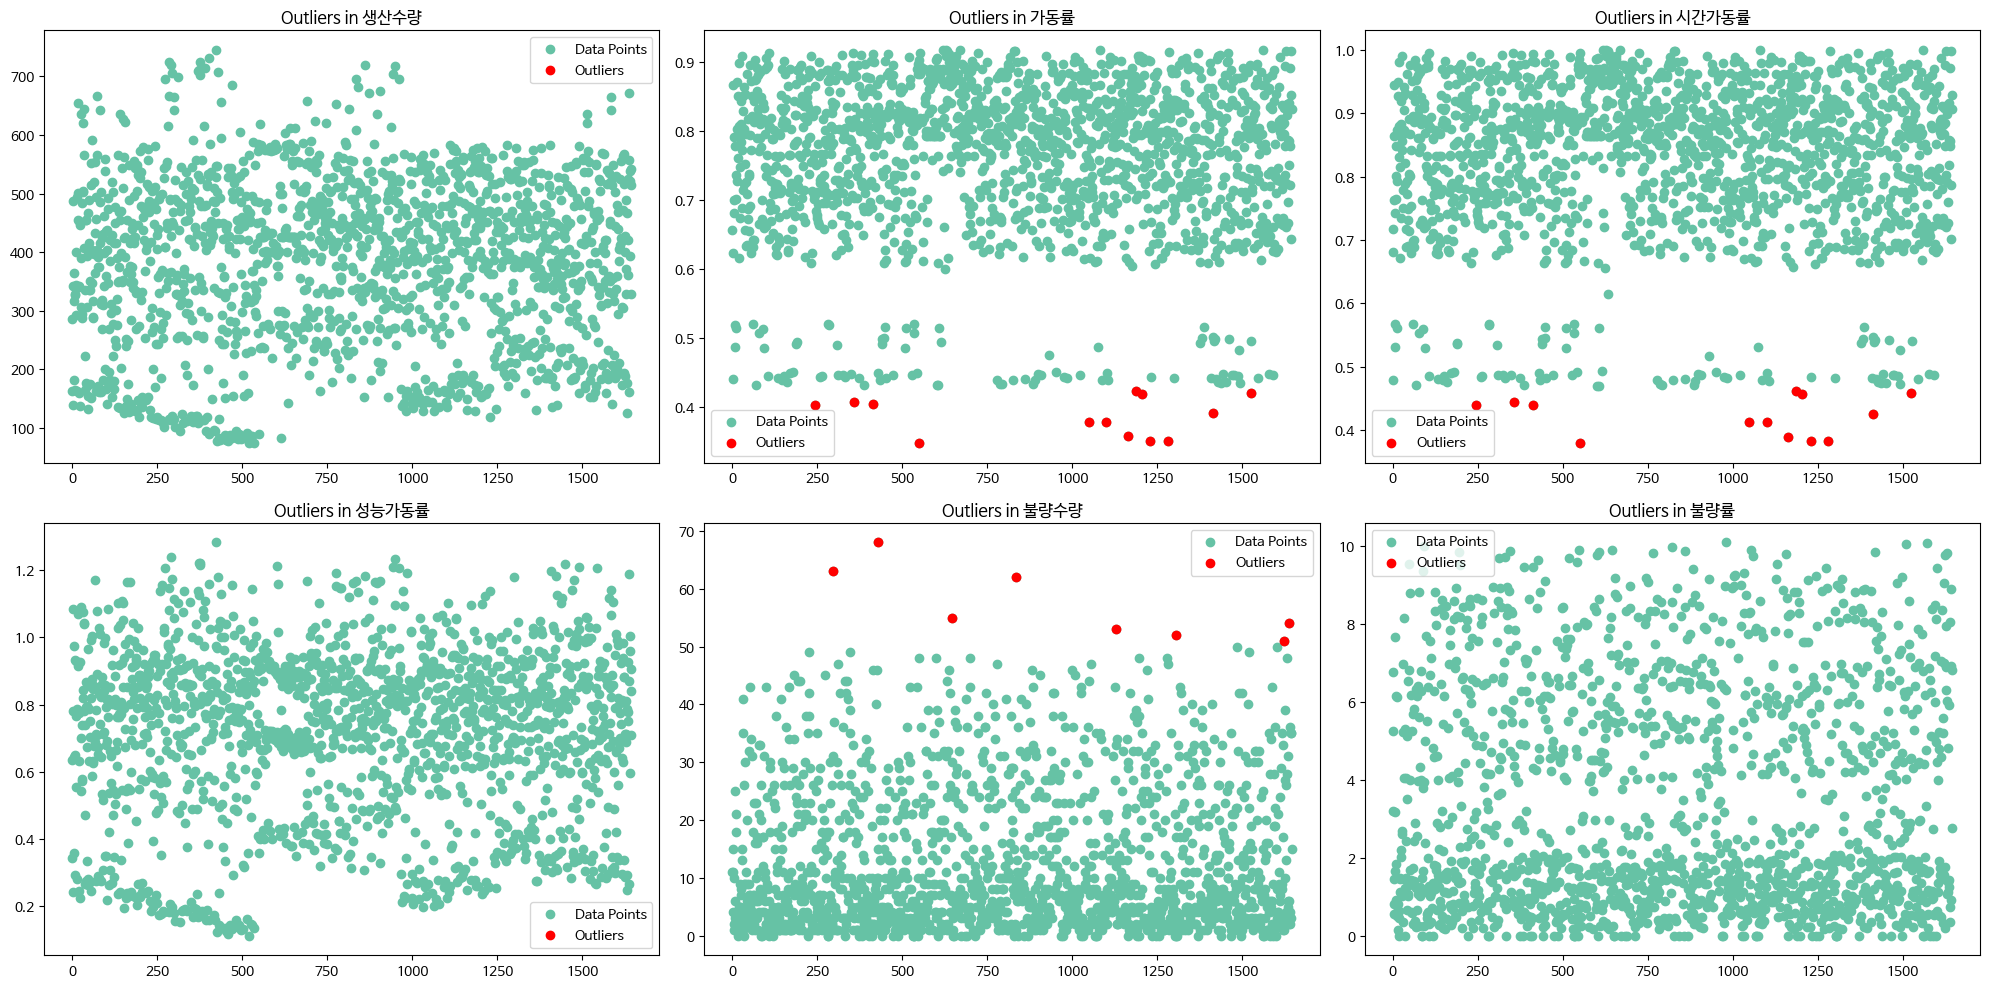

In [ ]:
numeric_df = merged_df.select_dtypes(include=[np.number])
numeric_df.drop(columns=['사번', '나이', '근속연수', '시간당생산수량'], inplace=True)

z_scores = np.abs(stats.zscore(numeric_df))
z_score_outliers = np.where(z_scores > 3)

plt.figure(figsize=(20, 10))

for i, column in enumerate(numeric_df.columns):
    plt.subplot(int(np.ceil(len(numeric_df.columns)/3)), 3, i + 1)
    plt.scatter(range(numeric_df.shape[0]), numeric_df[column], label='Data Points')
    plt.scatter(z_score_outliers[0][z_score_outliers[1] == i], numeric_df.iloc[z_score_outliers[0][z_score_outliers[1] == i]][column], color='red', label='Outliers')
    plt.title(f'Outliers in {column}')
    plt.legend()

plt.tight_layout()
plt.show()

# EDA

## 1. 상관관계 분석
> **상관계수를 분석하여 특징들 간의 관계 분석**

- 큰 상관관계를 가지고있는 변수들을 분석하였음
- 가동률과 시간가동률은 6개의 데이터를 제외한 모든 데이터가 선형관계를 가지고 있다.

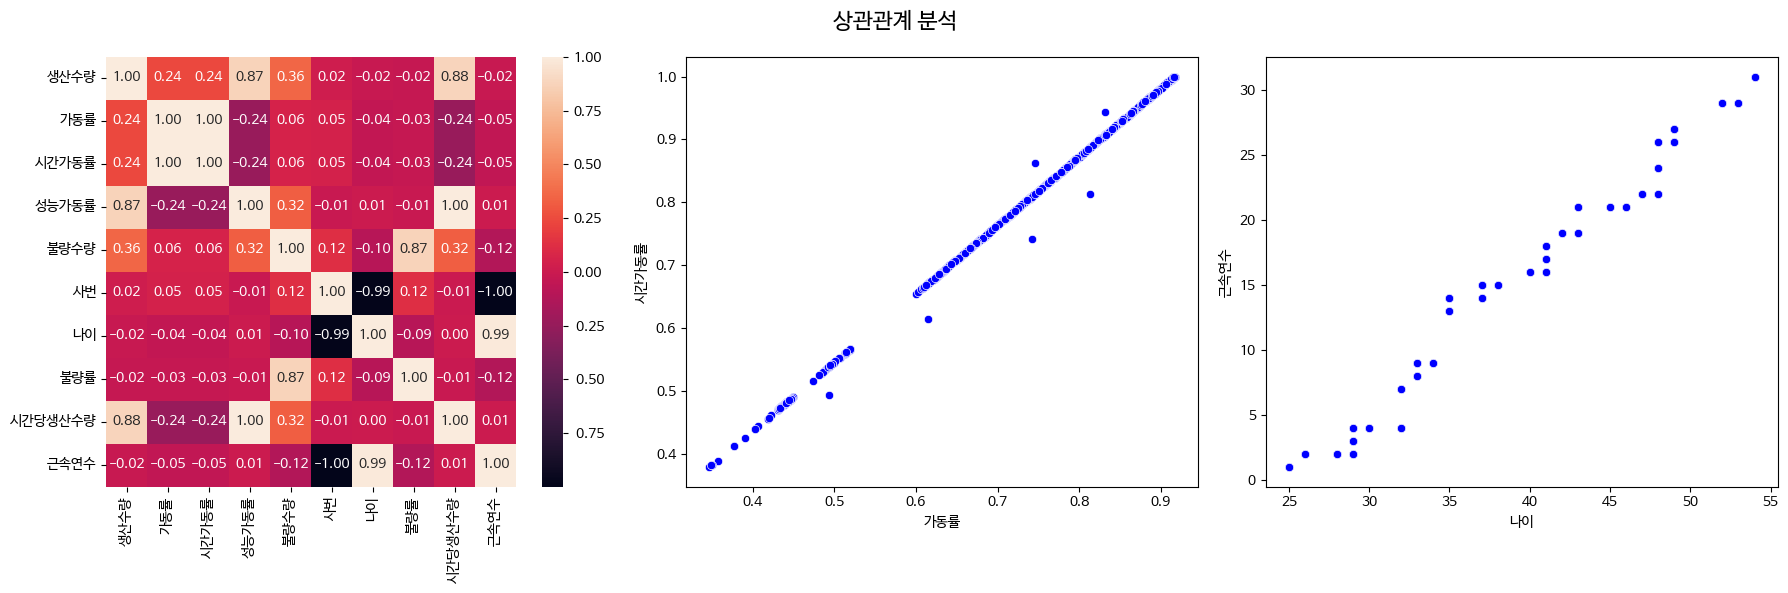

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(merged_df.corr(), annot=True, fmt='.2f')

plt.subplot(1, 3, 2)
sns.scatterplot(x='가동률', y='시간가동률', data=merged_df, color='blue')

plt.subplot(1, 3, 3)
sns.scatterplot(x='나이', y='근속연수', data=merged_df, color='blue')


plt.suptitle("상관관계 분석", fontsize=16)
plt.tight_layout()
plt.show()

## 2. 시계열 분석

> **날짜에 따른 성능가동률의 변화를 확인**

- LINE_A의 성능가동률이 5~7월에 큰 폭으로 증가하였다.

- LINE_A, B 의 8월 성능 가동률이 떨어지는 모습을 보여준다.

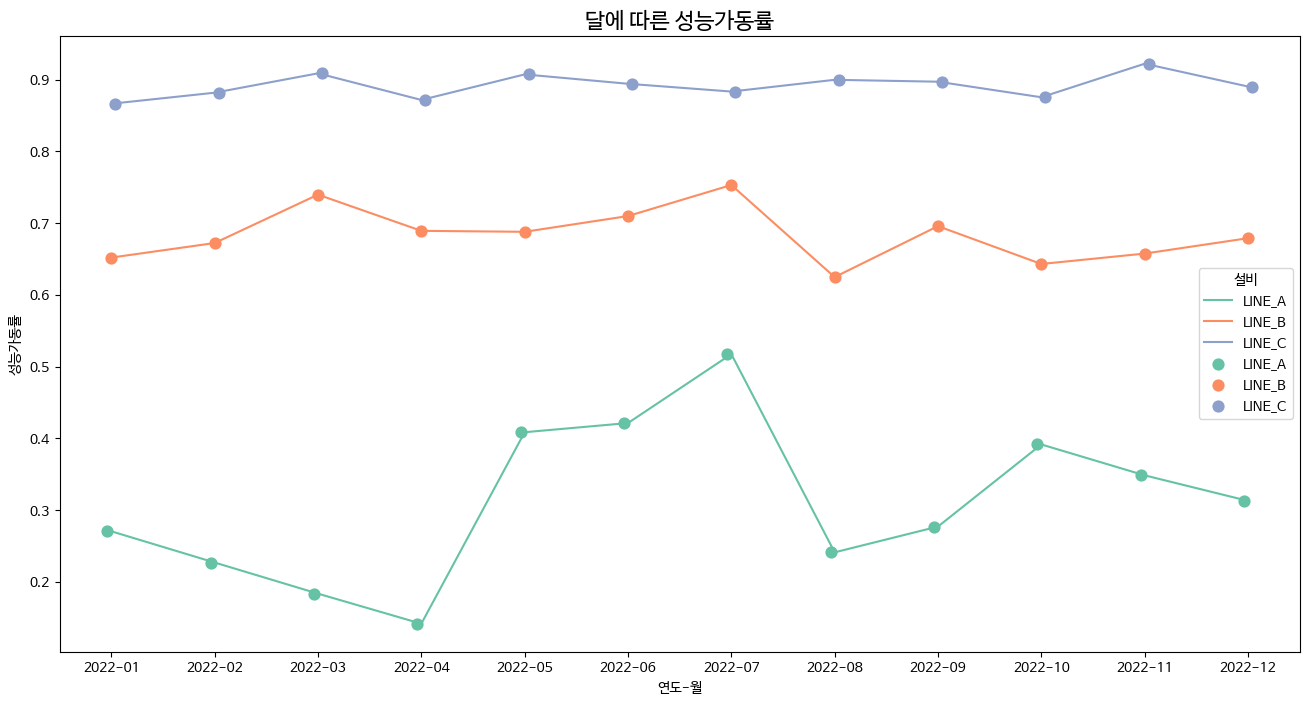

In [ ]:
time_data = merged_df.copy()
time_data['연도-월'] = time_data['작업일자'].dt.to_period('M').astype(str)
time = time_data.groupby(['연도-월', '설비'])[['성능가동률']].mean().reset_index()

plt.figure(figsize=(16, 8))
sns.lineplot(x='연도-월', y='성능가동률', hue='설비', data=time)
sns.pointplot(x='연도-월', y='성능가동률', hue='설비', data=time, markers='o', linestyles='', dodge=True)
plt.title('달에 따른 성능가동률', fontsize=16)
plt.show()

### LINE_A의 성능가동률

#### 가설1
- 4월과 5월의 성능가동률에 큰 차이가 있기에 공정에 문제가 있다고 판단하여 가설1로 설정

[전체 가설 이동](#scrollTo=_hypothesis_)

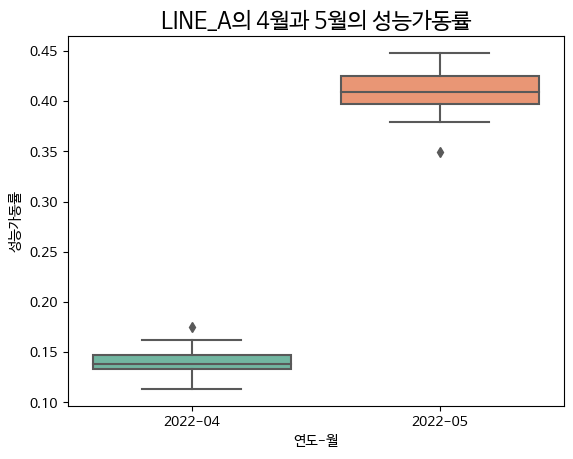

In [ ]:
line_a = time_data[(time_data['설비'] == 'LINE_A') & ((time_data['연도-월'] == '2022-04') | (time_data['연도-월'] == '2022-05'))]

sns.boxplot(x='연도-월', y='성능가동률', data=line_a)
plt.title('LINE_A의 4월과 5월의 성능가동률', fontsize=16)
plt.show()

## 3. Feature EDA
> **각 Feature를 시각화하여 데이터의 특징 확인과 가설 수립**

### **1) 설비 라인**

> **설비 라인별 생산성 차이 확인**

In [ ]:
def make_boxplot(data, pivot, columns, order, title):
    data[pivot] = pd.Categorical(data[pivot], categories=order, ordered=True)

    x = len(columns) // 2
    y = len(columns) // 2 + len(columns) % 2
    z = 1

    plt.figure(figsize=(8,8))
    for i in columns:
        plt.subplot(x, y, z)
        sns.boxplot(x=pivot, y=i, data=data)
        plt.xticks(rotation=(45))
        z += 1

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

def make_boxplot2(data, pivot, columns, order, title, loc):
    data[pivot] = pd.Categorical(data[pivot], categories=order, ordered=True)

    x = len(columns) // 2
    y = len(columns) // 2 + len(columns) % 2
    z = 1

    plt.figure(figsize=(12,8))
    for i in columns:
        plt.subplot(x, y, z)
        sns.boxplot(x=pivot, y=i, data=data, hue='설비')
        plt.xticks(rotation=(45))
        z += 1
        plt.legend(loc=loc)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

#### 가설2
- 설비 라인별 성능가동률의 평균을 확인하여 차이가 있는 것을 확인하여 가설 2를 설정

[전체 가설 이동](#scrollTo=_hypothesis_)

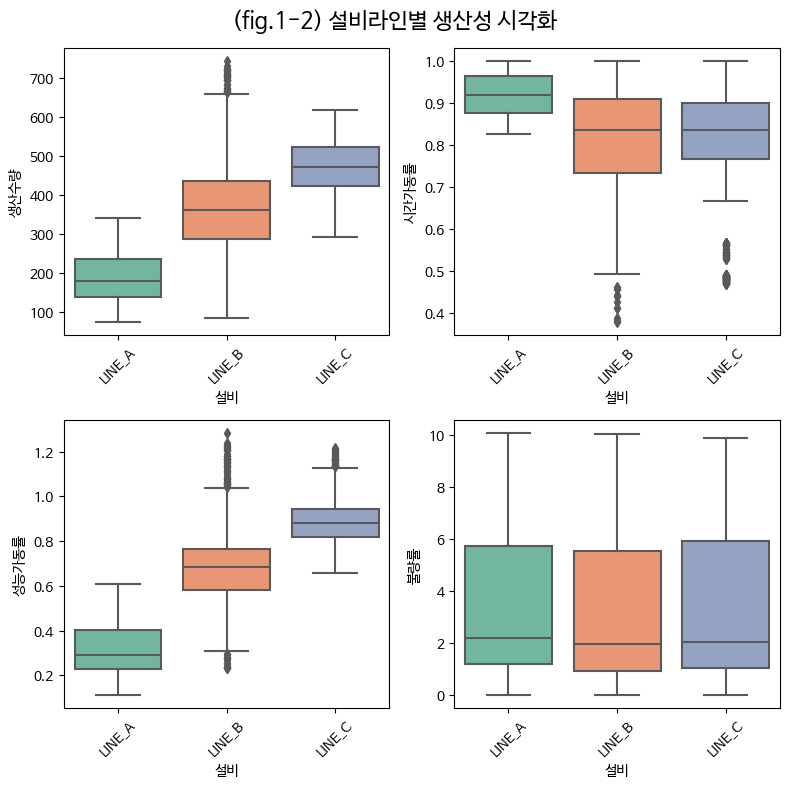

In [ ]:
columns = ['생산수량', '시간가동률', '성능가동률', '불량률']
order = ['LINE_A', 'LINE_B', 'LINE_C']
make_boxplot(merged_df, '설비', columns, order, '(fig.1-2) 설비라인별 생산성 시각화')

---
### **2) 근속연수**
> **근속연수에 따른 생산성 차이 확인**

#### 가설3
- 약 4년 차 이하의 경우와 24년 차 이상의 경우 **불량률이 급격하게 증가**하는 것으로 나타난다.
- 근속연수에 따른 불량률 시각화를 통하여 근속연수에 따른 불량률의 차이가 있는 것을 확인하여 가설3을 설정

[전체 가설 이동](#scrollTo=_hypothesis_)

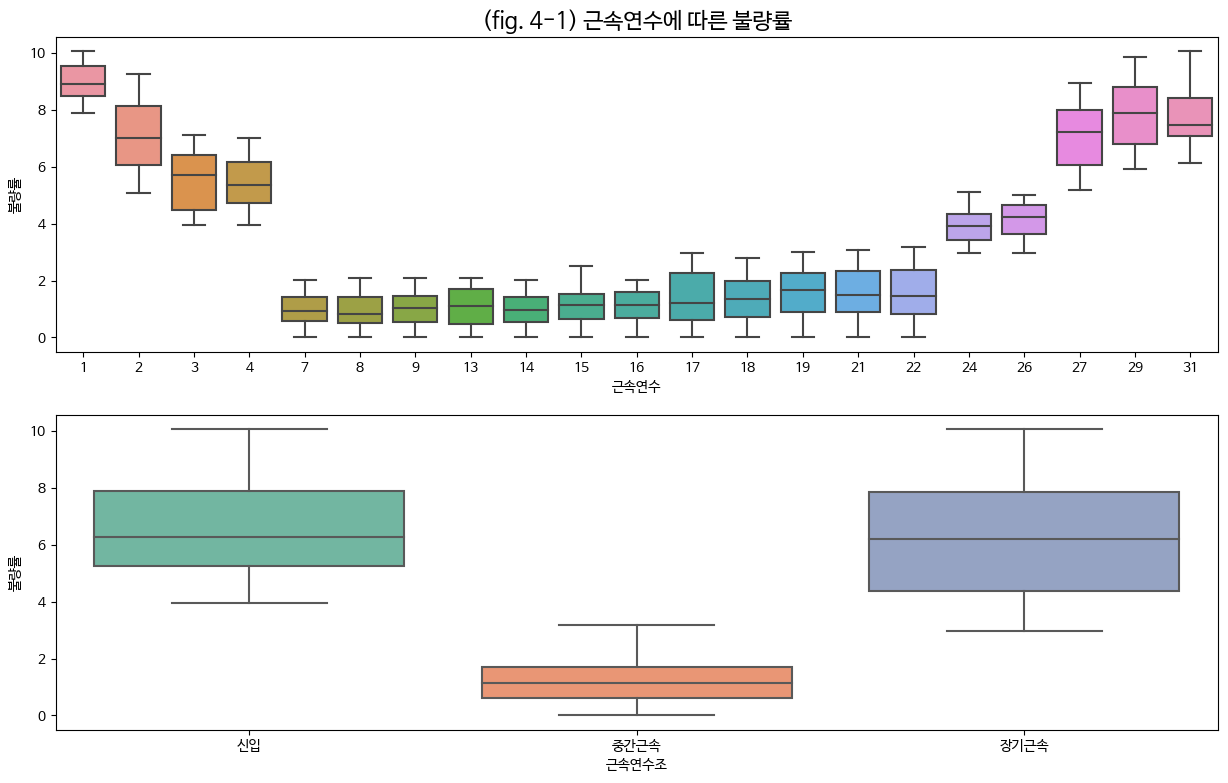

In [ ]:
plt.figure(figsize=(15, 9))

plt.subplot(2, 1, 1)
sns.boxplot(x='근속연수', y='불량률', data=merged_df)
plt.title('(fig. 4-1) 근속연수에 따른 불량률', fontsize=16)

def classification_years(years):
  if years > 4 and years < 24:
      return '중간근속'
  elif years >= 24:
      return '장기근속'
  else:
      return '신입'

merged_df['근속연수조'] = merged_df['근속연수'].apply(classification_years)

plt.subplot(2, 1, 2)
sns.boxplot(x='근속연수조', y='불량률', data=merged_df, order=['신입', '중간근속', '장기근속'])
plt.show()

---
### **3) 성별**
**성별에 따른 생산성 차이 확인.**

#### 가설4
- LINE_B에서 여성의 불량률이 남성에 비하여 조금 더 높은편으로 보인다.
- 성별에 따른 가동률과 불량률을 시각화하여 성별에 따른 차이가 있는 것을 확인하여 가설4를 설정

[전체 가설 이동](#scrollTo=_hypothesis_)

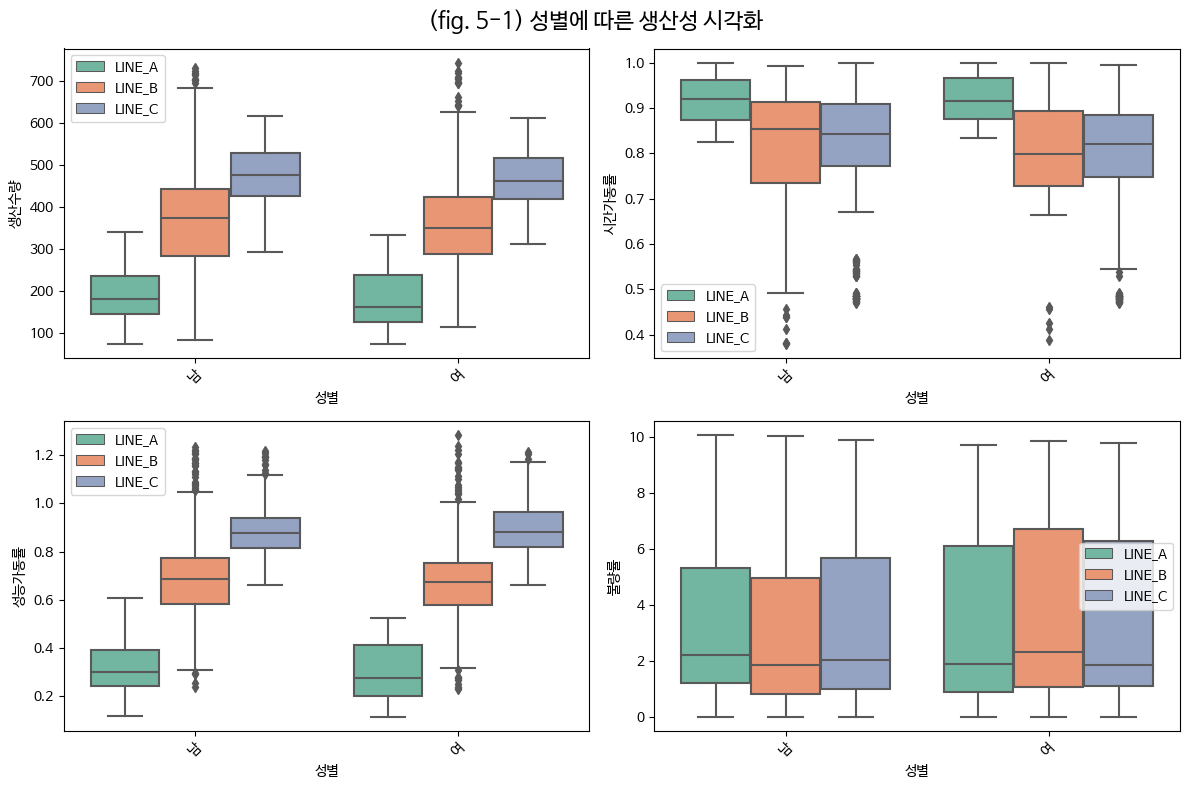

In [ ]:
columns = ['생산수량', '시간가동률', '성능가동률', '불량률']
order = ['남', '여']
make_boxplot2(merged_df, '성별', columns, order, '(fig. 5-1) 성별에 따른 생산성 시각화', 'best')

---
### **4) 최종학력**
> **최종학력에 따른 생상성 차이 확인**

#### 가설5
- 최종학력에 따라 생산량과 가동률은 변동이 없다.
- 불량률의 경우 최종학력이 높을수록 점차 감소하는 경향을 보인다.
- 최종학력에 따른 가동률을 시각화하여 최종학력에 따른 불량률 차이가 있는 것을 확인하여 가설5를 설정

[전체 가설 이동](#scrollTo=_hypothesis_)

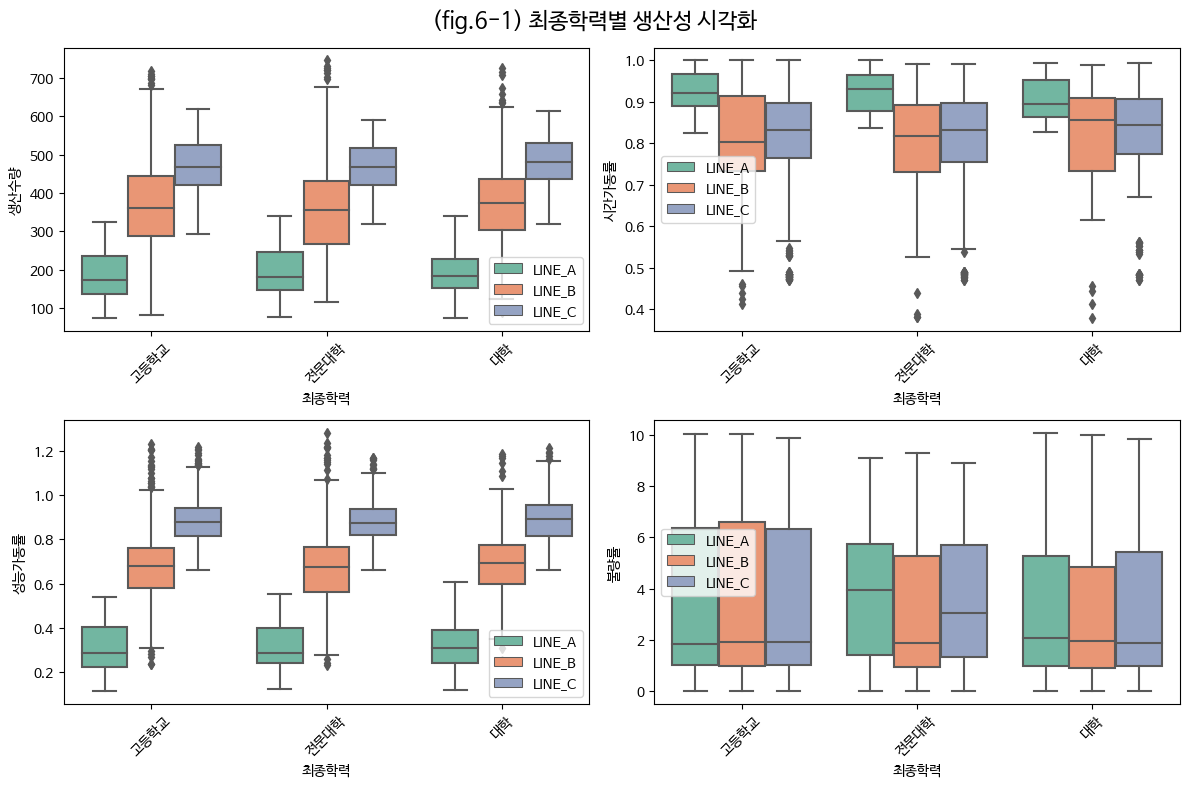

In [ ]:
columns = ['생산수량', '시간가동률', '성능가동률', '불량률']
order = ['고등학교', '전문대학', '대학']
make_boxplot2(merged_df, '최종학력', columns, order, '(fig.6-1) 최종학력별 생산성 시각화', 'best')

# 가설 (hypothesis)

1. 설비 LINE_A의 4월과 5월의 성능가동률에 차이가 있는것을 확인하여 가설 1을 도출하였다. [가설1 이동](#scrollTo=_1)
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} \ $) : 4월과 5월의 성능가동률은 통계적으로 같다.
  - 대립가설 ($H_{1} : \mu_{1} \neq \mu_{2} \ $) : 4월과 5월의 성능가동률은 통계적으로 차이가 있다.

2. 설비 라인별 성능가동률의 평균을 확인하여 차이가 있는 것을 확인하여 가설 2를 도출하였다. [가설2 이동](#scrollTo=_2)
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} \ $) : 설비 라인별 성능가동률의 평균은 동일하다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 설비 라인별 성능가동률의 평균은 하나 이상 다르다.

3. 근속연수 시각화를 통하여 근속연수에 따른 불량률의 차이가 있는 것을 확인하여 가설3을 도출하였다. [가설3 이동](#scrollTo=_3)
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} $) : 근속연수에 따른 불량률에 차이가 없다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 근속연수가 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.
  
4. 성별에 따른 가동률과 불량률을 시각화하여 성별에 따른 차이가 있는 것을 확인하여 가설4를 도출하였다. [가설4 이동](#scrollTo=_4)
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} $) : 남성과 여성의 가동률과 불량률에 차이가 없다
  - 대립가설 ($H_{1} : \mu_{1} \neq \mu_{2} $) : 남성과 여성의 가동률과 불량률의 차이가 통계적으로 유의하다.

5. 최종학력에 따른 가동률을 시각화하여 최종학력에 따른 불량률 차이가 있는 것을 확인하여 가설5를 도출하였다. [가설5 이동](#scrollTo=_5)
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} $) : 최종학력 수준에 따른 불량률에 차이가 없다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 최종학력 수준에서 불량률에 차이가 있다.

# 4. 데이터 분석

## 가설검정

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats as sp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

alpha = 0.05

### 가설1 : 시간에 따른 성능가동률
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} \ $) : 4월과 5월의 성능가동률은 통계적으로 같다.
  - 대립가설 ($H_{1} : \mu_{1} \neq \mu_{2} \ $) : 4월과 5월의 성능가동률은 통계적으로 차이가 있다.

In [ ]:
merged_df['작업일자'] = merged_df['작업일자'].astype(str)

A_4M = merged_df[(merged_df['작업일자'].str[:7] == '2022-04') & (merged_df['설비'] == 'LINE_A')]
A_5M = merged_df[(merged_df['작업일자'].str[:7] == '2022-05') & (merged_df['설비'] == 'LINE_A')]

_, pval = sp.stats.ttest_ind(A_4M['성능가동률'], A_5M['성능가동률'], equal_var=False)

print(f'p-value: {np.round(pval, 4)}')

if pval >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
  print('귀무가설: 4월과 5월의 성능가동률은 통계적으로 같다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')
  print('대립가설: 4월과 5월의 성능가동률은 통계적으로 차이가 있다.')

p-value: 0.0
p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.
대립가설: 4월과 5월의 성능가동률은 통계적으로 차이가 있다.


### 가설2: 설비별 성능가동률의 평균 시각화

  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} \ $) : 설비들의 평균 성능가동률은 모두 동일하다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 설비들의 평균 성능가동률은 적어도 하나 이상 다르다.

In [ ]:
model = ols('성능가동률 ~ C(설비)', merged_df).fit()
anova_lm(model)

if anova_lm(model)['PR(>F)'][0] >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
  print('귀무가설: 4월과 5월의 성능가동률은 통계적으로 같다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')
  print('대립가설: 4월과 5월의 성능가동률은 통계적으로 차이가 있다.')

p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.
대립가설: 4월과 5월의 성능가동률은 통계적으로 차이가 있다.


### 가설3 : 근속연수에 따른 불량률

  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} $) : 근속연수에 따른 불량률에 차이가 없다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 근속연수가 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.

In [ ]:
model = ols('불량률 ~ C(근속연수)', merged_df).fit()
display(anova_lm(model))
print('\n')

if anova_lm(model)['PR(>F)'][0] >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
  print('귀무가설: 근속연수에 따른 불량률에 차이가 없다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')
  print('대립가설: 근속연수가 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.')

,df,sum_sq,mean_sq,F,PR(>F)
C(근속연수),20.0,12214.971742,610.748587,880.204685,0.0
Residual,1625.0,1127.540527,0.693871,NaN,NaN




p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.
대립가설: 근속연수가 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.


### 가설4 : 성별에 따른 가동률과 불량률
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} $) : 남성과 여성의 불량률에 차이가 없다
  - 대립가설 ($H_{1} : \mu_{1} \neq \mu_{2} $) : 남성과 여성의 불량률의 차이가 통계적으로 유의하다.

In [ ]:
male_fault_rate = merged_df[merged_df['성별'] == '남']['불량률']
female_fault_rate = merged_df[merged_df['성별'] == '여']['불량률']

t_stat, p_val = sp.stats.ttest_ind(male_fault_rate, female_fault_rate, equal_var=False)

print(f"t-Statistic: {np.round(t_stat, 4)}, p-Value: {np.round(p_val, 4)}")

if p_val >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
  print('귀무가설: 성별에 따른 불량률에 차이가 없다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')
  print('대립가설: 성별에 따라 불량률이 유의미하게 다르다.')

t-Statistic: -3.2437, p-Value: 0.0012
p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.
대립가설: 성별에 따라 불량률이 유의미하게 다르다.


### 가설5 : 최종학력에 따른 불량률
  - 귀무가설 ($H_{0} : \mu_{1} = \mu_{2} = \mu_{3} $) : 최종학력 수준에 따른 불량률에 차이가 없다.
  - 대립가설 ($H_{A} : \mu_{i} \neq \mu_{j} \ for \ some \ i \ and \ j $) : 최종학력 수준에서 불량률에 차이가 있다.

In [ ]:
model = ols('불량률 ~ C(최종학력)', merged_df).fit()
display(anova_lm(model))
print('\n')

a = merged_df[merged_df['최종학력'] == '고등학교']['불량률'].mean()
b = merged_df[merged_df['최종학력'] == '전문대학']['불량률'].mean()
c = merged_df[merged_df['최종학력'] == '대학']['불량률'].mean()

print('최종학력별 평균 불량률')
print(f'고등학교: {a} \n전문대학: {b} \n대학: {c}')
print('\n')

if anova_lm(model)['PR(>F)'][0] >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
  print('귀무가설: 최종학력에 따른 불량률에 차이가 없다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')
  print('대립가설: 최종학력이 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.')

,df,sum_sq,mean_sq,F,PR(>F)
C(최종학력),2.0,52.447502,26.223751,3.241942,0.039338
Residual,1643.0,13290.064767,8.088901,NaN,NaN




최종학력별 평균 불량률
고등학교: 3.533925988619972 
전문대학: 3.3487594398686427 
대학: 3.0982742694094707


p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.
대립가설: 최종학력이 낮거나 높은 그룹에서 불량률이 유의미하게 다르다.


# 5. 결론

### 결론 1 -> 설비 LINE_A의 달별 성능가동률 차이
- 설비 LINE_A의 4월과 5월의 성능가동률에 차이가 있는것이 증명되었다. 이 부분을 면밀히 검토하여 성능가동률 차이의 원인을 파악하고 해결한다면 생산성 향상에 도움이 될 것으로 판단된다.
<br>

### 결론 2 -> 설비별 성능가동률의 평균 시각화
- 설비에 따라 성능가동률의 평균이 다르다는 것이 증명되었다.
- 설비 LINE_A의 경우 성능가동률이 매우 낮으므로 설비의 노후화에 따른 성능 차이가 존재할 가능성이 있다. 이러한 부분을 경제성 분석을 통해 설비 교체 유무 등 원인 파악과 해결이 필요하다.
<br>

### 결론 3 -> 근속연수에 따른 성능가동률
- 근속연수에 따른 성능가동률의 평균 차이가 존재한다는 것을 확인했다. 이를 통해 중간근속에 비해 신입과 장기근속이 장비 가동 중 설비 목표 성능 달성이 미흡한 것을 확인 할 수 있었다.
- 즉, 신입과 장기근속은 장비 가동 중 작업 집중도가 떨어진다고 판단되며 작업에 집중할 수 있게끔 작업환경 개선이 필요 해보인다.
<br>

### 결론 4 -> 성별에 따른 가동률과 불량률
- 남성과 여성의 불량률에 차이가 발생하며 여성 작업자의 경우 불량률의 비율이 더 높은 것으로 확인된다. 여성작업자의 경우 불량률이 높은 이유를 확인하고 조치가 필요할 것이다.
<br>

### 결론 5 -> 최종학력에 따른 불량률 차이
- 최종학력이 높아질수록 불량률이 낮아지는 것으로 판단되며 고등학교와 전문대학의 경우 추가적인 교육이 필요하다고 판단된다.

# 참고문헌
- [markdown 작성법](https://youtu.be/BeSTy3oN5c8?si=Kb3vBeToWctPAooy)

- [plt 경고 무시](https://velog.io/@guide333/%EC%9E%90%EC%A3%BC-%EC%93%B0%EB%8A%94-%EC%BD%94%EB%93%9C-waring-ignore-%EB%B6%80%ED%98%B8%EC%82%AC%EC%9A%A9matplot)

- [seaborn 색상 설정](https://velog.io/@imindude/%ED%8C%8C%EC%9D%B4%EC%8D%AC-seaborn-%EB%AA%A8%EB%93%88%EC%9D%98-color-palette)

- [마크다운 수식 작성법(TEX)](https://khw11044.github.io/blog/blog-etc/2020-12-21-markdown-tutorial2/#10%EC%82%BC%EA%B0%81%ED%95%A8%EC%88%98-%EC%8B%B8%EC%9D%B8-%EC%BD%94%EC%8B%B8%EC%9D%B8-%ED%83%84%EC%A0%A0%ED%8A%B8-%EC%84%B8%ED%83%80)